In [9]:
import os
import glob
from backend.params import *
import tensorflow as tf


2023-11-24 15:30:37.457894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 15:30:37.916159: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-24 15:30:37.990302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-24 15:30:37.990331: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [11]:
local_model_directory = os.path.join(LOCAL_REGISTRY_PATH)
local_model_paths = glob.glob(f"{local_model_directory}/*")


most_recent_model_path_on_disk = sorted(local_model_paths)[-1]

tf.keras.models.load_model(most_recent_model_path_on_disk)


2023-11-24 15:35:07.319631: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-24 15:35:07.320808: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-24 15:35:07.320909: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (JarisLaptop): /proc/driver/nvidia/version does not exist
2023-11-24 15:35:07.322987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import cv2
import shutil
from PIL import Image

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Tensorflow
import tensorflow as tf


# Variables #

In [14]:
# These 20 words were selected based on the amount of samples available
# selected_words = [
#     'like', 'work', 'play', 'take', 'call',
#     'go', 'study', 'give', 'write', 'yesterday',
#     'far', 'hot', 'cold', 'good', 'bad',
#     'computer', 'apple', 'doctor', 'family', 'dog'
# ]
selected_words = ['work','study', 'write', 'hot', 'cold', 'family']
n_classes = len(selected_words)

# Absolute main path
main_path = '../data/'

# Frame sampling parameters
frames_per_video = 10
target_size = (150, 150)

# Dataset multiplier
number_of_augmentations = 3

# Train split parameters
train_size = 0.7


# 1) Load Data #

In [15]:
# Absolute main path
# main_path = '../data/'

# Read JSON file into a DataFrame with unprocessed instance col
wlas_df = pd.read_json(main_path + 'WLASL_v0.3.json')


In [16]:
def get_videos_ids(json_list):
    """
    function to check if the video id is available in the dataset
    and return the viedos ids of the current instance

    Input: instance json list
    Output: list of videos_ids
    """
    videos_list = []
    for ins in json_list:
        video_id = ins['video_id']
        if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
            videos_list.append(video_id)
    return videos_list


In [17]:
def get_json_features(json_list):
    """
    function to check if the video id is available in the dataset
    and return the viedos ids and url or any other featrue of the current instance

    input: instance json list
    output: list of videos_ids
    """
    videos_ids = []
    videos_urls = []
    for ins in json_list:
        video_id = ins['video_id']
        video_url = ins['url']
        if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
            videos_ids.append(video_id)
            videos_urls.append(video_url)
    return videos_ids, videos_urls


In [18]:
# Open JSON file (read only)
with open(main_path+'WLASL_v0.3.json', 'r') as data_file:
    json_data = data_file.read()

instance_json = json.loads(json_data)


In [19]:
# Get available video ids for all rows in wlas_df and add to new col 'videos_id'
wlas_df['videos_ids'] = wlas_df['instances'].apply(get_videos_ids)
wlas_df


,gloss,instances,videos_ids
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra...","[69241, 07069, 07068, 07070, 07099, 07074]"
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f...","[69302, 65539, 17710, 17733, 65540, 17734, 177..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[12328, 12312, 12311, 12338, 12313, 12314, 123..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[05728, 05749, 05750, 05729, 05730, 65167, 057..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[09848, 09869, 09849, 09850, 09851, 65328, 09854]"
...,...,...,...
1995,washington,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[62393, 62394, 62395, 62396, 62398]"
1996,waterfall,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[62488, 62489, 62490, 62492, 62493]"
1997,weigh,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_...","[62782, 62783, 62785]"
1998,wheelchair,"[{'bbox': [415, 86, 1811, 1080], 'fps': 25, 'f...","[63044, 63046, 63047, 63050]"


In [20]:
# Create separate DataFrame for available information in each instance
features_df = pd.DataFrame(columns=['word', 'video_id', 'url'])

for row in wlas_df.iterrows():
    # Extract ids and urls for each row
    ids, urls = get_json_features(row[1][1])
    # Initialize a list matching the length (n) of found ids containing the word
    word = [row[1][0]] * len(ids)
    # Using zip to create new df with:
    # n * word in gloss col (e.g. 6 * book)
    # Unique id and url in ids and url col respectively
    df = pd.DataFrame(list(zip(word, ids, urls)), columns = features_df.columns)
    # Append temporary df to feature_df
    features_df = pd.concat([features_df, df], ignore_index=True)

# Renaming index col to index
features_df.index.name = 'index'
features_df


,word,video_id,url
index,,,
0,book,69241,http://aslbricks.org/New/ASL-Videos/book.mp4
1,book,07069,https://signstock.blob.core.windows.net/signsc...
2,book,07068,https://s3-us-west-1.amazonaws.com/files.start...
3,book,07070,https://media.asldeafined.com/vocabulary/14666...
4,book,07099,http://www.aslsearch.com/signs/videos/book.mp4
...,...,...,...
11975,wheelchair,63047,https://www.signingsavvy.com/signs/mp4/5/5233.mp4
11976,wheelchair,63050,http://www.aslsearch.com/signs/videos/wheelcha...
11977,whistle,63186,https://media.spreadthesign.com/video/mp4/13/9...


# 2) Define 20 target classes #

In [21]:
selected_df = features_df[features_df['word'].isin(selected_words)]
selected_df


,word,video_id,url
index,,,
256,hot,69368,http://aslbricks.org/New/ASL-Videos/hot.mp4
257,hot,28125,http://www.aslsearch.com/signs/videos/heat2.mp4
258,hot,28108,https://s3-us-west-1.amazonaws.com/files.start...
259,hot,28109,https://signstock.blob.core.windows.net/signsc...
260,hot,28110,https://signstock.blob.core.windows.net/signsc...
...,...,...,...
1430,cold,11628,https://media.asldeafined.com/vocabulary/14668...
1431,cold,11621,https://media.spreadthesign.com/video/mp4/13/3...
1432,cold,11633,https://www.signingsavvy.com/signs/mp4/22/2275...


In [29]:
for video_id in selected_df['video_id']:
    if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
        cap = cv2.VideoCapture(f'{main_path}videos/{video_id}.mp4')
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        selected_df.loc[selected_df['video_id'] == video_id, ['video_length']] = int(length)
    pass

selected_df = selected_df.reset_index(drop=True)
input_length = len(selected_df)
selected_df.head(20)


,word,video_id,url,video_length
0,hot,69368,http://aslbricks.org/New/ASL-Videos/hot.mp4,57.0
1,hot,28125,http://www.aslsearch.com/signs/videos/heat2.mp4,71.0
2,hot,28108,https://s3-us-west-1.amazonaws.com/files.start...,69.0
3,hot,28109,https://signstock.blob.core.windows.net/signsc...,59.0
4,hot,28110,https://signstock.blob.core.windows.net/signsc...,35.0
5,hot,28111,https://signstock.blob.core.windows.net/signsc...,35.0
6,hot,28112,https://media.asldeafined.com/vocabulary/14686...,78.0
7,hot,28115,https://www.signingsavvy.com/signs/mp4/14/1423...,34.0
8,hot,28116,https://www.signingsavvy.com/signs/mp4/6/6109.mp4,44.0
9,hot,28107,https://media.spreadthesign.com/video/mp4/13/5...,81.0


In [23]:
for video_id in features_df['video_id']:
    if os.path.exists(f'{main_path}videos/{video_id}.mp4'):
        cap = cv2.VideoCapture(f'{main_path}videos/{video_id}.mp4')
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        features_df.loc[features_df['video_id'] == video_id, ['video_length']] = int(length)
    pass

features_df = features_df.reset_index(drop=True)
features_df


,word,video_id,url,video_length
0,book,69241,http://aslbricks.org/New/ASL-Videos/book.mp4,75.0
1,book,07069,https://signstock.blob.core.windows.net/signsc...,30.0
2,book,07068,https://s3-us-west-1.amazonaws.com/files.start...,68.0
3,book,07070,https://media.asldeafined.com/vocabulary/14666...,86.0
4,book,07099,http://www.aslsearch.com/signs/videos/book.mp4,87.0
...,...,...,...,...
11975,wheelchair,63047,https://www.signingsavvy.com/signs/mp4/5/5233.mp4,51.0
11976,wheelchair,63050,http://www.aslsearch.com/signs/videos/wheelcha...,88.0
11977,whistle,63186,https://media.spreadthesign.com/video/mp4/13/9...,89.0
11978,whistle,63188,https://www.signingsavvy.com/signs/mp4/9/9961.mp4,46.0


In [43]:
features_df[features_df['video_id'] == '20982']


,word,video_id,url,video_length
414,family,20982,https://signstock.blob.core.windows.net/signsc...,36.0


# 3) Defining the Input/Features: X #

In [30]:
# Initialize empty array of desired shape
X = np.empty((input_length, frames_per_video, *target_size, 3), dtype=np.uint8)

# Function to perform frame sampling
def sample_frames(video_path, frames_per_video, total_frames):
    frames = []
    cap = cv2.VideoCapture(video_path)

    frame_indices = []

    while len(set(frame_indices)) != frames_per_video:
        frame_indices = sorted(np.random.uniform(0, total_frames-5, frames_per_video).astype(int))

    frame_counter = 0

    try:
        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break

            if frame_counter in frame_indices:
                # Resize frame to required size
                frame = cv2.resize(frame, target_size)
                # CV2 output BGR -> converting to RGB
                # frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # Append to list of frames
                # frames.append(frame_rgb)
                frames.append(frame)

            frame_counter += 1

            if len(frames) == frames_per_video:
                break

    finally:
        cap.release()

    return frames


In [31]:
np.random.seed(10)

for i, row in selected_df.iterrows():
    video_id = row['video_id']
    total_frames = row['video_length']
    video_path = f'../data/videos/{video_id}.mp4'

    sampled_frames = sample_frames(video_path, frames_per_video, total_frames)

    # Assign sampled frames to results array
    X[i] = np.array(sampled_frames)


In [32]:
if X.shape == (len(selected_df), frames_per_video, *target_size, 3):
    print(f'✅ X has been initialized with Shape {X.shape}!')
else:
    print('❌ X has not been initialized properly!')


✅ X has been initialized with Shape (63, 10, 150, 150, 3)!


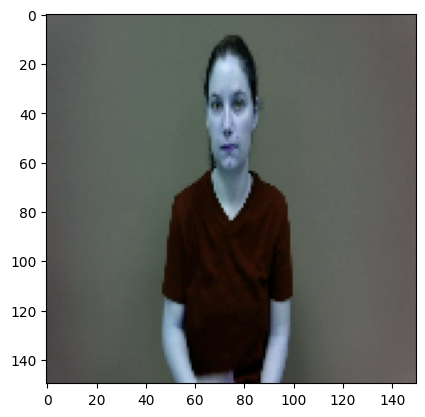

In [33]:
plt.imshow(X[0][0])


# 4) Defining the Output/Target: y #

In [39]:
label_encoder = LabelEncoder()

selected_df['encoded_word'] = label_encoder.fit_transform(selected_df['word'])
y_cat = tf.keras.utils.to_categorical(selected_df['encoded_word'], num_classes=n_classes)
label_encoder.classes_


array(['cold', 'family', 'hot', 'study', 'work', 'write'], dtype=object)

In [35]:
if y_cat.shape == (input_length, n_classes):
    print(f'✅ y has been initialized with Shape {y_cat.shape}!')
else:
    print('❌ y has not been initialized properly!')


✅ y has been initialized with Shape (63, 6)!


# 5) Restore sampled frames into .mp4 files #

In [530]:
def frames_to_video(sampled_frames, output_path, fps=frames_per_video):
    height, width, _ = sampled_frames[0].shape
    fourcc = cv2.VideoWriter.fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in sampled_frames:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video.write(frame_rgb)

    video.release()


In [531]:
def generate_processed_videos(X):
    output_folder = os.path.dirname('../data/processed_videos/')

    # Remove the folder if it exists
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)

    os.makedirs(output_folder)  # Recreate the folder

    # 'X' is a 5-dimensional numpy array with shape (num_videos, frames_per_video, height, width, channels)
    for i, sampled_frames in enumerate(X):
            video_path = f'../data/processed_videos/processed_{i}.mp4'  # Output path for each video
            frames_to_video(sampled_frames, video_path)  # Convert frames to video


# 6) Create Train / Validation split #

In [532]:
X_train, X_val, y_cat_train, y_cat_val = train_test_split(X,
                                                          y_cat,
                                                          train_size=train_size,
                                                          random_state=1,
                                                          stratify=y_cat)


# 7) Video augmentation for increased data set size #

In [533]:
def augment_frame_params(frame_width, frame_height):
    """
    Generate random parameters for image augmentation.

    Args:
    - frame_width (int): Width of the frame.
    - frame_height (int): Height of the frame.

    Returns:
    Variables containing randomly generated parameters for frame augmentation.
        - angle (float): Random rotation between 0 and 15 degrees.
        - flip (float): Random value for horizontal mirroring.
        - x_trans (int): Random translation along the x-axis between -20 and 20 pixels.
        - y_trans (int): Random translation along the y-axis between -20 and 20 pixels.
        - scale (float): Random zoom factor between 0.8 and 1.2.
        - crop_size (int): Random size for cropping within the frame.
        - alpha (float): Random value for brightness and contrast adjustment between 0.7 and 1.3.
        - beta (int): Random value for brightness and contrast adjustment between -20 and 20.
    """
    # Random rotation between -15 and 15 degrees
    angle = np.random.uniform(0, 15)
    # Random horizontal mirroring
    flip = np.random.rand()
    # Random translation
    x_trans = np.random.randint(-20, 20)
    y_trans = np.random.randint(-20, 20)
    # Random zoom
    scale = np.random.uniform(0.8, 1.2)
    # Random cropping (with centralized region)
    crop_size = np.random.randint(0.8 * min(frame_width, frame_height), min(frame_width, frame_height))
    # Changes in brightness, contrast, and saturation
    alpha = np.random.uniform(0.7, 1.3)
    beta = np.random.randint(-20, 20)

    return angle, flip, x_trans, y_trans, scale, crop_size, alpha, beta


In [534]:
def augment_frame(frame, angle, flip, x_trans, y_trans, scale, crop_size, alpha, beta, target_size):
    """
    Apply various random transformations to an input image/frame.

    Args:
    - frame (numpy.ndarray): Input image/frame to be augmented.
    - angle (float): Angle for random rotation.
    - flip (float): Value for horizontal flipping (50% chance).
    - x_trans (int): Random translation along the x-axis.
    - y_trans (int): Random translation along the y-axis.
    - scale (float): Random zoom factor.
    - crop_size (int): Random size for cropping within the frame.
    - alpha (float): Value for brightness and contrast adjustment.
    - beta (int): Value for brightness and contrast adjustment.

    Returns:
    numpy.ndarray: Augmented image/frame after applying random transformations.
    """
    # Random rotation by an angle
    rows, cols, _ = frame.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    frame = cv2.warpAffine(frame, M, (cols, rows))
    # Horizontal flipping
    if flip > 0.5:  # 50% chance of flipping
        frame = cv2.flip(frame, 1)
    # Random translation
    M = np.float32([[1, 0, x_trans], [0, 1, y_trans]]) # type: ignore
    frame = cv2.warpAffine(frame, M, (cols, rows)) # type: ignore
    # Random zoom
    frame = cv2.resize(frame, None, fx=scale, fy=scale)
    # Random cropping (with centralized region)
    x = int((rows - crop_size) / 2)
    y = int((cols - crop_size) / 2)
    frame = frame[x:x + crop_size, y:y + crop_size]
    # Changes in brightness, contrast, and saturation
    frame = cv2.convertScaleAbs(frame, alpha=alpha, beta=beta)
    # Resize frame back to height 150, width 150
    frame = cv2.resize(frame, target_size)

    return frame


In [535]:
def multiply_data(X, frames_per_video):
    X_temp = np.empty((len(X), frames_per_video, *target_size, 3), dtype=np.uint8)
    frame_height = X.shape[2]
    frame_width = X.shape[3]

    for i in range(len(X)):
        angle, flip, x_trans, y_trans,\
        scale, crop_size, alpha, beta = augment_frame_params(frame_height, frame_width)
        for j in range(frames_per_video):
            sampled_frame = X[i][j]
            aug_frame = augment_frame(sampled_frame,
                                      angle,
                                      flip,
                                      x_trans,
                                      y_trans,
                                      scale,
                                      crop_size,
                                      alpha,
                                      beta,
                                      target_size)
            X_temp[i][j] = aug_frame

    return X_temp


In [536]:
# Initialize a copy of preprocessed X and categoried y
X_aug = X_train.copy()
y_aug = y_cat_train.copy()

# Multiply dataset by defined param
for _ in range(number_of_augmentations):
    X_temp = multiply_data(X_train, frames_per_video)
    # Returns X_aug with shape (n * 219, 10, 150, 150, 3)
    X_aug = np.concatenate((X_aug, X_temp), axis=0)
    # Returns y_aug with shape (n * 219, 20)
    y_aug = np.concatenate((y_aug, y_cat_train), axis=0)


# 7) Testing output and generating videos #

In [537]:
if X_aug.shape == ((number_of_augmentations + 1) * len(X_train), frames_per_video, *target_size, 3):
    print(f'✅ X_aug has been initialized with Shape {X_aug.shape}!')
else:
    print('❌ X_aug has not been initialized properly!')

if y_aug.shape == ((number_of_augmentations + 1) * len(y_cat_train), n_classes):
    print(f'✅ y_aug has been initialized with Shape {y_aug.shape}!')
else:
    print('❌ y_aug has not been initialized properly!')

print()

if X_val.shape == (round(len(X) * (1 - train_size)), frames_per_video, *target_size, 3):
    print(f'✅ X_val has been initialized with Shape {X_val.shape}!')
else:
    print('❌ X_val has not been initialized properly!')

if y_cat_val.shape == (round(len(y_cat) * (1 - train_size)), n_classes):
    print(f'✅ y_cat_val has been initialized with Shape {y_cat_val.shape}!')
else:
    print('❌ y_cat_val has not been initialized properly!')


✅ X_aug has been initialized with Shape (176, 10, 150, 150, 3)!
✅ y_aug has been initialized with Shape (176, 6)!

✅ X_val has been initialized with Shape (19, 10, 150, 150, 3)!
✅ y_cat_val has been initialized with Shape (19, 6)!


In [538]:
# generate_processed_videos(X_aug)
